In [20]:
# Import the libraries
import torch

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import gc
from random import choice, randint, seed
from tqdm.auto import tqdm

%matplotlib inline

In [21]:
# Set seed to repeat the results
random_seed = 1

np.random.seed(random_seed)

seed(random_seed)

torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Generating dataset

Parameters:
<ul>
    <li> <b>n_samples</b> - number of generated images (int: n_sample=100) </li>
    <li> <b>resolution</b> - size of images pxl (tuple: resolution=(64, 64)) </li>
    <li> <b>figure_types</b> - random types of generated figures (list: figure_types=['traingle', 'square', 'circle', 'pentagon', 'hexagon']) </li>
    <li> <b>sizes</b> - random size of figures in range (tuple: sizes=(5, 13)) [atention: sizes[1] < resolution[0]/2 - 1] [size_1 < size_2] </li>
    <li> <b>colors</b> - random color of figures (list: colors=['#FBC618', '#0414F6', '#AAC628']) </li>
    <li> <b>rotation_angles</b> - random rotation angles in range (tuple: rotation_angles=(10, 180)) [angle_1 < angle_2]</li>
    <li> <b>path</b> - path to folder for saving the generated data </li>
</ul> <br>

#### Functions

In [22]:
# Create dataset of figure's parameters
def generate_dataset(resolution, n_samples, figure_types, sizes, colors, rotation_angles, path):
    
    # Figure size (c) is low than (a/2 - 1); a - numbers of pixels
    # Picture field - [-a/2, a/2]
    # Center of picture shift is low than +-(a-c)
    
    rot_angl = {'triangle': 120,'square': 90, 'circle': 1, 'pentagon': 72, 'hexagon': 60}

    random_data = {'figure': [choice(figure_types) for i in range(n_samples)], 
                   'size': [randint(sizes[0], sizes[1]) for i in range(n_samples)], 
                   'color': [choice(colors) for i in range(n_samples)], 
                   'rotation_angle': [(randint(rotation_angles[0], rotation_angles[1])) for i in range(n_samples)]}
    
    for i, angl in enumerate(random_data['rotation_angle']):
        random_data['rotation_angle'][i] = angl % rot_angl[random_data['figure'][i]]
        
    image_data = pd.DataFrame(random_data)

    # Add center coordinations
    image_data['center_x'] = np.random.randint(-resolution[0]/2 + image_data['size'], resolution[0]/2 - image_data['size'])
    image_data['center_y'] = np.random.randint(-resolution[0]/2 + image_data['size'], resolution[0]/2 - image_data['size'])
    
    image_data.index.name = 'ID'

    image_data.to_csv(path + '\\image_data.csv')

    return image_data

In [23]:
# Generate picture of figures
def generate_image(resolution, k, image_data, path=None):
    
    dpi = plt.rcParams['figure.dpi'] # dpi for transform inch to pixel

    # Figure types
    mark_dict = {'circle': 'o', 
                 'triangle': (3, 0, image_data['rotation_angle'].values[k]), 
                 'square': (4, 0, image_data['rotation_angle'].values[k]), 
                 'pentagon': (5, 0, image_data['rotation_angle'].values[k]),
                 'hexagon': (6, 0, image_data['rotation_angle'].values[k])}
    mark = mark_dict[image_data['figure'].values[k]]

    # Some variables
    x = image_data['center_x'].values[k]
    y = image_data['center_y'].values[k]
    marksize = image_data['size'].values[k]
    col = image_data['color'].values[k]
    pxl_size_x = resolution[0]/dpi
    pxl_size_y = resolution[1]/dpi
    x_lim = [-resolution[0]/2, resolution[0]/2]
    y_lim = [-resolution[1]/2, resolution[1]/2]

    # Create picture
    fig = plt.figure(figsize=(pxl_size_x, pxl_size_y))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y, marker=mark, markersize=marksize, color=col)
    plt.axis('off')
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    # plt.savefig(path + f'\\ID-{k}.png', bbox_inches=0)

    # Plot to array
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    #np.save(path + f'img_array_{k}.npy', data)
    
    plt.close()

    return data

In [24]:
# Test input data
def testing_input(n_samples, resolution, figure_types, sizes, colors, rotation_angles, path):
     # n_samples
    if not (isinstance(n_samples, int) and n_samples > 0 and n_samples <= 100000):
        return False

    # resolution
    if not (isinstance(resolution, tuple) and len(resolution) == 2 and
            resolution[0] > 0 and resolution[1] > 0):
        return False

    # figure_types
    valid_figure_types = ['triangle', 'square', 'circle', 'pentagon', 'hexagon']
    if not all(i in valid_figure_types for i in figure_types):
        return False

    # sizes
    if not (isinstance(sizes, tuple) and len(sizes) == 2 and
            sizes[0] > 0 and sizes[1] > 0 and sizes[1] <= resolution[0] / 2 - 1
            and sizes[0] < sizes[1]):
        return False
    
    # rotation_angels
    if not (isinstance(rotation_angles, tuple) and len(rotation_angles) == 2 and
            rotation_angles[0] < rotation_angles[1]):
        return False

    return True
        

In [25]:
# Start all generation functions
def generate_image_dataset(n_samples, resolution, figure_types, sizes, colors, rotation_angles, path):
    if testing_input(n_samples, resolution, figure_types, sizes, colors, rotation_angles, path):

        image_data = generate_dataset(resolution, n_samples, figure_types, sizes, colors, rotation_angles, path)
        
        plot_list = []
        
        for k in tqdm(range(n_samples)):
            
            plot_list.append(generate_image(resolution, k, image_data, path))
        
            if len(plot_list) >= 10000:
                if not os.path.exists(path + 'img_arrays.npz'):
                    np.savez_compressed(path + 'img_arrays.npz', plot_list)
                    del plot_list
                    gc.collect()
                    plot_list = []
                else:
                    img_zip = np.load(path + 'img_arrays.npz')
                    img_arr = img_zip['arr_0']
                    new_arr = np.concatenate((img_arr, plot_list))
                    np.savez_compressed(path + 'img_arrays.npz', new_arr)
                    del img_zip, img_arr, new_arr, plot_list
                    gc.collect()
                    gc.collect()
                    plot_list = []
                    
        if plot_list:
            if not os.path.exists(path + 'img_arrays.npz'):
                np.savez_compressed(path + 'img_arrays.npz', plot_list)
            else:
                img_zip = np.load(path + 'img_arrays.npz')
                img_arr = img_zip['arr_0']
                new_arr = np.concatenate((img_arr, plot_list))
                np.savez_compressed(path + 'img_arrays.npz', new_arr)
                del img_zip, img_arr, new_arr, plot_list  
                gc.collect()      
        return print('Access!')
    else:
        return print('Error input data! Check description!')

#### Generation

In [26]:
# NUM_IMAGES = 50000

# generate_image_dataset(n_samples=NUM_IMAGES, 
#                         resolution=(64, 64), 
#                         figure_types=['triangle','square','circle', 'pentagon', 'hexagon'], 
#                         sizes=(5, 31), 
#                         colors=['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080', '#008000', '#000000'], 
#                         rotation_angles=(0, 180), 
#                         path='C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\')

In [39]:
NUM_IMAGES = 10000

generate_image_dataset(n_samples=NUM_IMAGES, 
                        resolution=(32, 32), 
                        figure_types=['hexagon', 'pentagon'], 
                        sizes=(10, 15), 
                        colors=['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080', '#008000', '#000000'], 
                        rotation_angles=(0, 180), 
                        path='C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\')

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_12460\3123051476.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
100%|██████████| 10000/10000 [05:18<00:00, 31.38it/s] 

Access!


In [28]:
# Figure types of generated images
df_data = pd.read_csv('C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\image_data.csv')
df_data['figure'].value_counts()

figure
pentagon    10071
square      10050
hexagon     10026
triangle    10012
circle       9841
Name: count, dtype: int64

In [29]:
# Load images zip and unzip
img_zip = np.load('C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\img_arrays.npz')
img_arr = img_zip['arr_0']

In [30]:
print(f"Dataset shape: {img_arr.shape} -> [images_number, height, width, color_channels]")

Dataset shape: (50000, 64, 64, 3) -> [images_number, height, width, color_channels]


In [31]:
img = img_arr[6]
type(img)
len(img)

64

In [32]:
img_tensor = torch.from_numpy(img)
img_tensor.shape

torch.Size([64, 64, 3])

In [33]:
import torchvision
img_PIL = torchvision.transforms.ToPILImage()(img)
img_tensor_gray = torchvision.transforms.Grayscale()(img_PIL)
img = torchvision.transforms.ToTensor()(img_tensor_gray)
img.shape


torch.Size([1, 64, 64])

(-0.5, 63.5, 63.5, -0.5)

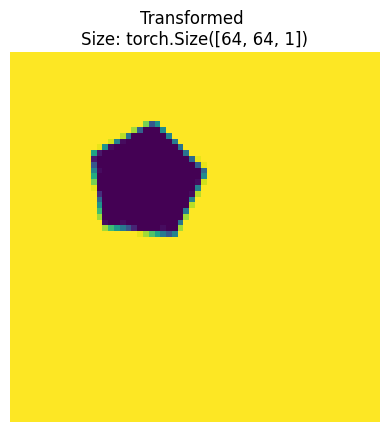

In [34]:
fig, ax = plt.subplots(1, 1)
transformed_image = img.permute(1, 2, 0) 
ax.imshow(transformed_image) 
ax.set_title(f"Transformed \nSize: {transformed_image.shape}")
ax.axis("off")

In [35]:
from PIL import Image
img_tensor_gray.save('Tensor_transform_grayscale.png')

#### Some test code

In [36]:
# # Picture visual
# dpi = 100
# for plot in img_ar:
#     fig = plt.figure(figsize=(64/dpi, 64/dpi), dpi=dpi)
#     plt.imshow(plot)
#     plt.axis('off')
#     plt.gray()
#     plt.show()

In [37]:
# # Initialization the generate function several times for low memory usage

# NUM_IMAGES = 50000
# BATCH_IMG = 10000
# OST_IMG = NUM_IMAGES - NUM_IMAGES * (NUM_IMAGES // BATCH_IMG)

# for i in range(NUM_IMAGES // BATCH_IMG):
#     random_seed += 1
#     np.random.seed(random_seed)
#     seed(random_seed)
#     generate_image_dataset(n_samples=BATCH_IMG, 
#                             resolution=(64, 64), 
#                             figure_types=['triangle','square','circle', 'pentagon', 'hexagon'], 
#                             sizes=(5, 31), 
#                             colors=['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080', '#008000', '#000000'], 
#                             rotation_angles=(0, 180), 
#                             path='C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\')
#     gc.collect()

# if OST_IMG != 0:
#     generate_image_dataset(n_samples=OST_IMG, 
#                             resolution=(64, 64), 
#                             figure_types=['triangle','square','circle', 'pentagon', 'hexagon'], 
#                             sizes=(5, 31), 
#                             colors=['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500', '#800080', '#008000', '#000000'], 
#                             rotation_angles=(0, 180), 
#                             path='C:\\Users\\User\\AppData\\Local\\Programs\\VS_Projects\Testing\\Figure project\\files\\')

In [38]:
# # Start all generation functions with saves
# def generate_image_dataset(n_samples, resolution, figure_types, sizes, colors, rotation_angles, path):
#     if testing_input(n_samples, resolution, figure_types, sizes, colors, rotation_angles, path):

#         if not os.path.exists(path + 'image_data.csv'):
#             image_data = generate_dataset(resolution, n_samples, figure_types, sizes, colors, rotation_angles, path)
#             image_data.to_csv(path + 'image_data.csv')
#         else:
#             image_data = pd.read_csv(path + 'image_data.csv')
#             image_data = pd.concat([image_data, generate_dataset(resolution, n_samples, figure_types, sizes, colors, rotation_angles, path)])
#             image_data.to_csv(path + 'image_data.csv')

#         plot_list = []
        
#         for k in tqdm(range(n_samples)):
            
#             plot_list.append(generate_image(resolution, k, image_data, path))
        

#         if not os.path.exists(path + 'img_arrays.npz'):
#             np.savez_compressed(path + 'img_arrays.npz', plot_list)
#             del plot_list
#             gc.collect()
#             plot_list = []
#         else:
#             img_zip = np.load(path + 'img_arrays.npz')
#             img_arr = img_zip['arr_0']
#             new_arr = np.concatenate((img_arr, plot_list))
#             np.savez_compressed(path + 'img_arrays.npz', new_arr)
#             del img_zip, img_arr, new_arr, plot_list
#             plot_list = []
#             gc.collect()
                    
#         if plot_list:
#             if not os.path.exists(path + 'img_arrays.npz'):
#                 np.savez_compressed(path + 'img_arrays.npz', plot_list)
#             else:
#                 img_zip = np.load(path + 'img_arrays.npz')
#                 img_arr = img_zip['arr_0']
#                 new_arr = np.concatenate((img_arr, plot_list))
#                 np.savez_compressed(path + 'img_arrays.npz', new_arr)
#                 del img_zip, img_arr, new_arr, plot_list  
#                 gc.collect()
#         return print('Access!')
#     else:
#         return print('Error input data! Check description!')